In [2]:
import requests
import bs4
import json
import arango

In [3]:
from selenium import webdriver 
from selenium.webdriver.chrome.options import Options
from selenium_stealth import stealth
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

chrome_options = Options()
# chrome_options.add_argument("--disable-extensions")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--no-sandbox") # linux only
chrome_options.add_argument("--headless=new") # for Chrome >= 109
chrome_options.set_capability("goog:loggingPrefs",{"performance": "ALL"})
# chrome_options.add_argument("--headless")
# chrome_options.headless = True # also works
driver = webdriver.Chrome(options=chrome_options)
stealth(
    driver,
    languages=["en-US", "en"],  # Specify the languages supported by the browser
    vendor="Google Inc.",       # Set the vendor of the browser
    platform="Win32",           # Specify the platform on which the browser is running
    webgl_vendor="Intel Inc.",   # Spoof the WebGL rendering engine vendor
    renderer="Intel Iris OpenGL Engine",  # Spoof the WebGL rendering engine renderer
    fix_hairline=True           # Enable fixing a specific issue related to headless browsing
)


In [4]:
import time

In [5]:
from arango import ArangoClient

# Initialize the client for ArangoDB.
client = ArangoClient(hosts="http://localhost:8529")

# Connect to "_system" database as root user.
sys_db = client.db("_system", username="root", password="openSesame")

# Create a new database named "test".
if sys_db.has_database("instagraph"):
    sys_db.delete_database("instagraph")

sys_db.create_database("instagraph")

# Connect to "test" database as root user.
db = client.db("instagraph", username="root", password="openSesame")

# Create a new collection named "students".
users = db.create_collection("users")
posts = db.create_collection("posts")
user_following=db.create_graph('user_following',[{
    'edge_collection': 'following',
    'from_vertex_collections': ['users'],
    'to_vertex_collections': ['users']
}])

In [6]:
start_users=['paulundbohne', 'brotundspiele.graz']

In [7]:
def search_key(d:list|dict, key='profile_id'):
    if not isinstance(d,(list,dict)):
        return None
    rvals=[]
    if isinstance(d, list):
        for e in d:
            rvals.append(search_key(e))
    else:
        for k,v in d.items():
            if k==key:
                return k,v
            else:
                rvals.append(search_key(v))
    rvals=[r for r in rvals if r is not None]
    if len(rvals)>0:
        return rvals[0]
    else:
        return None

In [8]:
import time
import random
def wait_user_time():
    time.sleep(random.uniform(2,5))

/tmp/ipykernel_32489/2622262973.py:11: RuntimeWarning: coroutine 'Response.finished' was never awaited
  response.finished()


paulundbohne {} [] [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[<div id="splash-screen" style="position:fixed;z-index:100;background:#fff;top:0;left:0;width:100%;height:100%"><style nonce="" type="text/css">html{overflow-y:scroll!important}</style><span style="position:absolute;bottom:32px;left:50%;margin:-36px 0 0 -36px;"></span></div>, <div id="mount_0_0_IB"></div>, <div hidden="" id="has-finished-comet-page" style="display: none;"></div>]

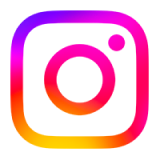
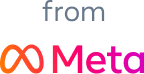

In [9]:
import nest_asyncio
import asyncio
from playwright.async_api import async_playwright, Response, Page
import atexit
from playwright_stealth import stealth_async
import re as rx

# Allow nested event loops
nest_asyncio.apply()
def record_following(response: Response):
    response.finished()
    start_id=rx.search(r'friendships/(\d+)/following', response.url)
    if start_id:
        following_data=response.json()
        id=start_id[1]
        found_followers=following_data['users']
        for user in found_followers:
            existing_users=list(users.find({
                'id':user['id']
            }, limit=1))
            if len(existing_users)==0:
                user['_key']=user['id']
                users.insert(user)
                user_following.insert_edge('following',{'_from':id,'_to':user['id']})
async def explore_following(page:Page,max_depth=8):
    wait_user_time()
    await page.get_by_text('following').click()
    wait_user_time()
    size=page.viewport_size
    for s in max_depth():
        await page.mouse.move(size['width']/2, size['height']/2, 3)
        await page.mouse.wheel(0,size['height']/2)
        wait_user_time()
    
    
    
async def explore_user(user_name=start_users[0]):
    pw = await async_playwright().start()
    browser = await pw.chromium.launch(headless=True)
    page = await browser.new_page()
    await stealth_async(page)
    page.on("response", record_following)

    # All methods are async (use the "await" keyword)
    await page.goto(f"https://instagram.com/{user_name}")
    src = await page.content()
    wait_user_time()
    page_bs=bs4.BeautifulSoup(src)
    jsons=[json.loads(s.text) for s in page_bs.find_all('script') if s.has_attr('data-sjs')]
    keys=['profile_id']
    results={}
    for k in keys:
        searched=[search_key(j, key=k) for j in jsons]
        values=[kv[1] for kv in searched if kv]
        if len(values)>0:
            results[k]=values[0]
        print(user_name, results, values, searched)
    print(page_bs.find_all('div'))
    await page.screenshot(path=f'users/{user_name}.png')
    await explore_following(page)
    # Function to close browser and stop Playwright
    async def shutdown_playwright():
        await browser.close()
        await pw.stop()

    # Register shutdown hook for when the program exits
    atexit.register(lambda: asyncio.run(shutdown_playwright()))

# Run the async main function
await explore_user()  # Use await directly instead of asyncio.run()

brotundspiele.graz {'profile_id': '9124397572'} ['9124397572'] [None, None, None, None, None, None, None, None, None, None, None, None, ('profile_id', '9124397572'), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
[<div id="splash-screen" style="position:fixed;z-index:100;background:#fff;top:0;left:0;width:100%;height:100%"><style nonce="8fnslTuk" type="text/css">html{overflow-y:scroll!important}</style><span style="position:absolute;bottom:32px;left:50%;margin:-36px 0 0 -36px;"></span></div>, <div id="mount_0_0_Rc"></div>, <div hidden="" id="has-finished-comet-page" style="display: none;"></div>]
<Response [401]>

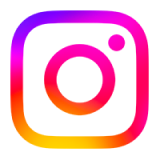
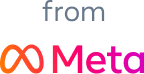

KeyError: 'users'

In [8]:
def explore_following(id, max_depth=8):
    max_id=0
    for i in range(max_depth):
        params={
            'count':12    
        }
        if i>0:
            params['max_id']=max_id
        following=requests.get(f"https://www.instagram.com/api/v1/friendships/{id}/following/",params)
        print(following)
        following_data=following.json()
        found_followers=following_data['users']
        for user in found_followers:
            existing_users=list(users.find({
                'id':user['id']
            }, limit=1))
            if len(existing_users)==0:
                user['_key']=user['id']
                users.insert(user)
                user_following.insert_edge('following',{'_from':id,'_to':user['id']})
        # users.insert_many(following_data['users'])
        max_id=following_data['next_max_id']
    
def explore_user(user_name):
    driver.get(f"https://www.instagram.com/{user_name}/")
    driver.get_log('performance')
    page_bs=bs4.BeautifulSoup(page_data.text)
    jsons=[json.loads(s.text) for s in page_bs.find_all('script') if s.has_attr('data-sjs')]
    keys=['profile_id']
    results={}
    for k in keys:
        searched=[search_key(j, key=k) for j in jsons]
        values=[kv[1] for kv in searched if kv]
        if len(values)>0:
            results[k]=values[0]
        print(user_name, results, values, searched)
    print(page_bs.find_all('div'))
    explore_following(results['profile_id'])
    # followers=f"https://www.instagram.com/api/v1/friendships/{id}/followers/?count=12"
explore_user(start_users[1])

In [12]:
logs = driver.get_log("performance")
print(logs)

InvalidArgumentException: Message: invalid argument: log type 'performance' not found
  (Session info: chrome=128.0.6613.84)
Stacktrace:
#0 0x62e9b53ef81a <unknown>
#1 0x62e9b50bde50 <unknown>
#2 0x62e9b5147568 <unknown>
#3 0x62e9b5132458 <unknown>
#4 0x62e9b5100093 <unknown>
#5 0x62e9b510109e <unknown>
#6 0x62e9b53b6a7b <unknown>
#7 0x62e9b53baa31 <unknown>
#8 0x62e9b53a2645 <unknown>
#9 0x62e9b53bb5a2 <unknown>
#10 0x62e9b538781f <unknown>
#11 0x62e9b53de618 <unknown>
#12 0x62e9b53de7e2 <unknown>
#13 0x62e9b53ee60c <unknown>
#14 0x7d9540c9ca94 <unknown>
#15 0x7d9540d29c3c <unknown>
